In [69]:
import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt

import torch, numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt
import copy

from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


SEED = 4200
torch.manual_seed(SEED)
np.random.seed(SEED)

torch.set_default_dtype(torch.float32)
torch.autograd.set_detect_anomaly(True)

import warnings
warnings.filterwarnings("ignore")

## Toy case models and datasets

In [70]:
boston = load_boston()
X = boston.data
y = boston.target

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)  

In [71]:
model = nn.Sequential(
    nn.Linear(13, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-1, weight_decay = 5e-4)
criterion = nn.MSELoss()

### Simple training loop 

In [72]:
train_losses = []

for epoch in range(100):
    # Forward pass
    
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Store loss value
    train_losses.append(loss.item())
    
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{100}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Epoch [10/100], Loss: 108.9392
Epoch [20/100], Loss: 43.4876
Epoch [30/100], Loss: 24.4725
Epoch [40/100], Loss: 18.0850
Epoch [50/100], Loss: 14.4142
Epoch [60/100], Loss: 12.0501
Epoch [70/100], Loss: 10.4739
Epoch [80/100], Loss: 9.5392
Epoch [90/100], Loss: 8.7902
Epoch [100/100], Loss: 8.1955
Test Loss: 12.1529


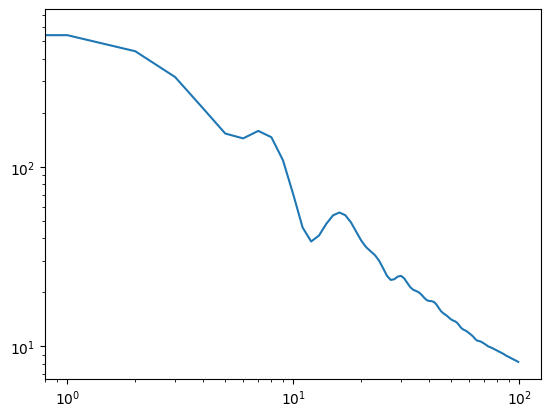

In [73]:
plt.loglog(train_losses)

### SCALTRA implementation - On the fly metalearning

In [104]:
class SCALTRA(nn.Module):
    def __init__(self, model, epochs, 
                 loss_criterion,
                 beta = 0.5, tau = 1e2, gamma = 0.9):
        super().__init__()

        self.gamma = gamma
        self.beta = beta

        self.B = []
        self.tau = []

        self.momentum = []

        for _, p in model.named_parameters():
            self.B.append(nn.Parameter(torch.randn(p.shape), requires_grad = True))
            self.tau.append(nn.Parameter(torch.ones(1)*tau, requires_grad = True))
            self.momentum.append(torch.zeros_like(p))

        self.params = nn.ParameterList(self.B + self.tau)

        # Some more initialization

        self.loss_criterion = loss_criterion
        self.meta_optimizer = torch.optim.Adagrad(params=self.parameters(), lr=1)
        self.epochs = epochs
        self.learning_rate = 1

    def forward(self, model, X, y):
        train_losses = []

        for _ in range(self.epochs):

            #new_params = []
            B_part_grad = []
            tau_part_grad = []

            for i, (_, p) in enumerate(model.named_parameters()):

                # Local optimization step
                if len(p.shape) == 1:
                    H = torch.linalg.inv(torch.outer(self.B[i],self.B[i]) + self.tau[i]*torch.eye(self.B[i].shape[0])) @ self.momentum[i]
                    #new_params.append(nn.Parameter(p - 1/(self.B[i]**2 + self.tau*torch.ones(self.B[i].shape[0])) * self.momentum[i], requires_grad = True))
                    B_part_grad.append(-self.learning_rate*self.gamma*(torch.autograd.grad(H,
                                                                                           self.B[i],
                                                                                           torch.ones_like(H),
                                                                                           retain_graph=True)[0]))
                    
                    tau_part_grad.append(-self.learning_rate*self.gamma*(torch.autograd.grad(H,
                                                                                             self.tau[i],
                                                                                             torch.ones_like(H),
                                                                                             retain_graph=True)[0]))

                else:
                    H = torch.linalg.inv(torch.matmul(self.B[i],torch.transpose(self.B[i],0,1)) + self.tau[i]*torch.eye(self.B[i].shape[0])) @ self.momentum[i]

                    #H = torch.linalg.inv(torch.matmul(self.params[i],torch.transpose(self.params[i],0,1)) + self.tau*torch.eye(self.params[i].shape[0])) @ self.momentum[i]
                    #new_params.append(nn.Parameter(p - torch.linalg.inv(torch.outer(self.B[i],self.B[i]) + self.tau*torch.eye(self.B[i].shape[0])) @ self.momentum[i], requires_grad = True))
                    B_part_grad.append(-self.learning_rate*self.gamma*(torch.autograd.grad(H,
                                                                                           self.B[i],
                                                                                           torch.ones_like(H),
                                                                                           retain_graph=True)[0]))
                    
                    tau_part_grad.append(-self.learning_rate*self.gamma*(torch.autograd.grad(H,
                                                                                             self.tau[i],
                                                                                             torch.ones_like(H),
                                                                                             retain_graph=True)[0]))

                with torch.no_grad():

                    # Convex smoothing

                    p.add_(-self.gamma*(self.learning_rate*H))
                

            #new_params = nn.ParameterList(new_params)

            loss = self.loss_criterion(model(X), y)

            # Zero gradients for optimizer parameters
            self.zero_grad()

            # Backward phase
            loss.backward()

            for i, (p, v) in enumerate(zip(model.parameters(), self.B)):
                v.grad = B_part_grad[i] * p.grad
                '''
                v.grad = torch.autograd.grad(inputs = new_params[i],
                                             outputs = v,
                                             grad_outputs=torch.ones_like(v),
                                             allow_unused=True)[0] @ p.grad
                '''

            for i, (p, v) in enumerate(zip(model.parameters(), self.tau)):
                v.grad = (tau_part_grad[i] * p.grad.mean())

            # Update optimizer parameters
            self.meta_optimizer.step()  

            # Update momentum
            for i, (_, p) in enumerate(model.named_parameters()):
                self.momentum[i] = self.beta * self.momentum[i] + (1 - self.beta) * p.grad


            train_losses.append(loss.detach().numpy())
            
            # Updating the learning rates

            self.gamma *= 0.9
            #self.learning_rate *= 0.9
            
        return train_losses

In [105]:
losses = {'Batch GD':np.zeros((100,100)),
          'ADAM':np.zeros((100,100)),
          'ADAGrad':np.zeros((100,100)),
          'SCALTRA':np.zeros((100,100))}

criterion = nn.MSELoss()

for i in tqdm(range(100)):
    model = nn.Sequential(
        nn.Linear(13, 30, bias=True),
        nn.ReLU(),
        nn.Linear(30, 1, bias=True)
    )

    optimizer = torch.optim.SGD(params=model.parameters(), lr=1e-3)
    train_losses = []

    for epoch in range(100):
        # Forward pass
        
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Store loss value
        train_losses.append(loss.item())
    
    losses['Batch GD'][i,:] = np.array(train_losses)

for i in tqdm(range(100)):
    model = nn.Sequential(
        nn.Linear(13, 30, bias=True),
        nn.ReLU(),
        nn.Linear(30, 1, bias=True)
    )

    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-1)
    train_losses = []

    for epoch in range(100):
        # Forward pass
        
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Store loss value
        train_losses.append(loss.item())
    
    losses['ADAM'][i,:] = np.array(train_losses)

for i in tqdm(range(100)):
    model = nn.Sequential(
        nn.Linear(13, 30, bias=True),
        nn.ReLU(),
        nn.Linear(30, 1, bias=True)
    )

    optimizer = torch.optim.Adagrad(params=model.parameters(), lr=1e-1)
    train_losses = []

    for epoch in range(100):
        # Forward pass
        
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Store loss value
        train_losses.append(loss.item())
    
    losses['ADAGrad'][i,:] = np.array(train_losses)

for i in tqdm(range(100)):
    model = nn.Sequential(
        nn.Linear(13, 30, bias=True),
        nn.ReLU(),
        nn.Linear(30, 1, bias=True)
    )

    optimizer = SCALTRA(model, 100, criterion, 0.1, 500)
    train_losses = optimizer.forward(model, X_train_tensor, y_train_tensor)
    
    losses['SCALTRA'][i,:] = np.array(train_losses)

100%|██████████| 100/100 [04:02<00:00,  2.42s/it]


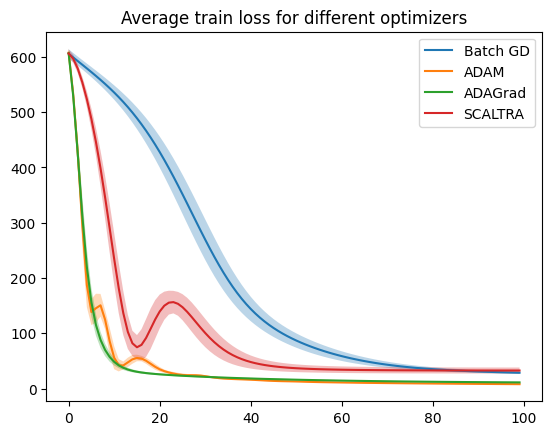

In [106]:
for key in losses.keys():
    mean = np.mean(losses[key], axis=0)
    UB = mean + np.std(losses[key], axis = 0)
    LB = mean - np.std(losses[key], axis = 0)
    plt.plot(mean, label = key)
    plt.fill_between(range(losses[key].shape[0]), UB, LB,alpha=0.3)
    plt.title('Average train loss for different optimizers')
    plt.legend()

______________

### SCALTRANet - DeepUnrolling SCA for neural network training

### Dataset of synthetic models for prelearning

In [107]:
class SyntheticModels():
    def __init__(self, model, features_num, output_size, M, s_sigma = 0.5, eps_sigma = 0.01, size = 1000, batch_size = 256):

        #self.model = model
        self.features_num = features_num
        self.output_size = output_size
        self.M = M

        self.size = size    # Size of the dataset
    
        self.s_sigma = s_sigma
        self.eps_sigma = eps_sigma

        self.batch_size = batch_size
        self.data = {}

        # Generating the dataset
        self.set_data(model)

    def set_tuple(self, model):
        cloned_model = copy.deepcopy(model)

        # Set the weights of the model
        with torch.no_grad():
            for p in cloned_model.parameters():
                p.copy_(torch.randn_like(p))
        
        x = torch.randn((self.M,self.features_num))
        y = cloned_model.forward(x) 
        y += torch.randn_like(y)*1e-2
        
        return (cloned_model, x, y)
    
    def set_data(self, model):
        for i in range(self.size):
            self.data[i] = self.set_tuple(model)
    
    '''
    def set_loader(self):
        return Data.DataLoader(dataset = Data.TensorDataset(self.y, self.x),
                               batch_size = self.batch_size,
                               shuffle = True)
    '''

In [118]:
model = nn.Sequential(
    nn.Linear(13, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-1, weight_decay = 5e-4)
criterion = nn.MSELoss()

In [119]:
synthetic_models = SyntheticModels(model, 13, 1, 300, size = 50, batch_size = 1)

### The unrolled architecture 

In [115]:
class SCALTRALayer(nn.Module):
    def __init__(self, model, 
                 learning_rate = 1,
                 tau = 100, gamma = 0.9):
        super().__init__()

        # Initialization of the learnable parameters
        #self.lambda_ = nn.Parameter(torch.ones(1)*lambda_, requires_grad = True)

        self.gamma = gamma
        self.learning_rate = learning_rate
        self.B = []
        self.tau = []

        for _, p in model.named_parameters():
            self.B.append(nn.Parameter(torch.ones(p.shape), requires_grad = True))
            self.tau.append(nn.Parameter(torch.ones(1)*tau, requires_grad = True))

        self.params = nn.ParameterList(self.B + self.tau)

    def forward(self, model, momentum):

        for i, (_, p) in enumerate(model.named_parameters()):

            # Local optimization step
            if len(p.shape) == 1:
                H = torch.linalg.inv(torch.outer(self.B[i],self.B[i]) + self.tau[i]*torch.eye(self.B[i].shape[0])) @ momentum[i]

            else:
                H = torch.linalg.inv(torch.matmul(self.B[i],torch.transpose(self.B[i],0,1)) + self.tau[i]*torch.eye(self.B[i].shape[0])) @ momentum[i]
            
            with torch.no_grad():

                p.add_(-self.gamma*self.learning_rate*H)
                
        return model
                

In [122]:
class SCALTRANet(nn.Module):
    def __init__(self, model, loss_criterion,
                 beta = 0.9, T = 10, learning_rate = 1, 
                 tau = 0.25, gamma = 0.99):
        
        super(SCALTRANet, self).__init__()
        
        # Number of iterations <-> number of layers
        #self.model = model
        self.T = T

        # Initialization of the learnable parameters
        self.tau_0 = torch.ones(T)*tau
        self.gamma_0 = torch.ones(T)*gamma
        for i in range(self.T):
            self.gamma_0[i] *= 0.99**i
            
        self.loss_criterion = loss_criterion

        self.beta = beta
        self.momentum = []
        self.train_losses = []

        for _, p in model.named_parameters():
            self.momentum.append(torch.zeros_like(p))

        # Defining the layers
        self.SCALTRA_layers = nn.ModuleList([SCALTRALayer(model,
                                                          learning_rate,
                                                          self.tau_0[i], 
                                                          self.gamma_0[i]
                                                          ) for i in range(self.T)])
        self.meta_optimizer = torch.optim.Adagrad(params=self.parameters(), lr=1)

    def reinitialization(self, model):
        
        for layer in model.modules():
            if isinstance(layer, torch.nn.Linear):
                torch.nn.init.xavier_uniform(layer.weight.data)

        return model
    
    def forward(self, model, X, y):
        M = copy.deepcopy(model)
        M = self.reinitialization(M)
       
        for i in tqdm(range(self.T-1)):
            model = copy.deepcopy(M)
            with torch.no_grad():
                M = copy.deepcopy(self.SCALTRA_layers[i].forward(model, self.momentum))
                
            loss = self.loss_criterion(M(X), y)

            # Zero gradients for optimizer parameters
            self.zero_grad()

            # Backward phase
            loss.backward(inputs = list(M.parameters()))

            # Update momentum
            for i, (_, p) in enumerate(M.named_parameters()):
                self.momentum[i] = self.beta * self.momentum[i] + (1 - self.beta) * p.grad

            # Update gradients

            self.train_losses.append(loss.detach().numpy())

        return model        

In [130]:
optimizer = SCALTRANet(synthetic_models.data[0][0], torch.nn.MSELoss(), T = 100, tau = 500)

In [131]:
optimizer.modules

<bound method Module.modules of SCALTRANet(
  (loss_criterion): MSELoss()
  (SCALTRA_layers): ModuleList(
    (0): SCALTRALayer(
      (params): ParameterList(
          (0): Parameter containing: [torch.float32 of size 30x13]
          (1): Parameter containing: [torch.float32 of size 30]
          (2): Parameter containing: [torch.float32 of size 1x30]
          (3): Parameter containing: [torch.float32 of size 1]
          (4): Parameter containing: [torch.float32 of size 1]
          (5): Parameter containing: [torch.float32 of size 1]
          (6): Parameter containing: [torch.float32 of size 1]
          (7): Parameter containing: [torch.float32 of size 1]
      )
    )
    (1): SCALTRALayer(
      (params): ParameterList(
          (0): Parameter containing: [torch.float32 of size 30x13]
          (1): Parameter containing: [torch.float32 of size 30]
          (2): Parameter containing: [torch.float32 of size 1x30]
          (3): Parameter containing: [torch.float32 of size 1]


In [132]:
m = optimizer.forward(synthetic_models.data[1][0], 
                      synthetic_models.data[1][1], 
                      synthetic_models.data[1][2])

100%|██████████| 99/99 [00:00<00:00, 105.58it/s]


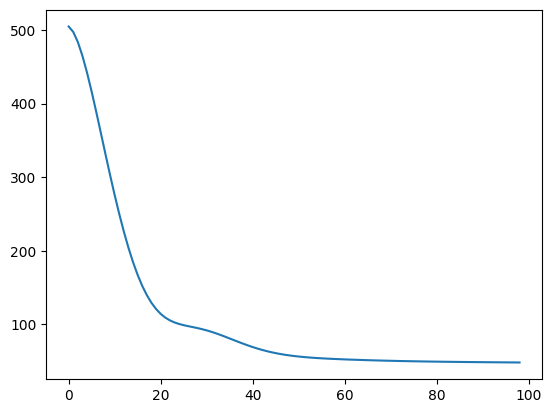

In [133]:
plt.plot(optimizer.train_losses)

### Online optimization loop for generalized L2O

In [127]:
def modelMSEloss(model1, model2):
    loss = 0
    for p, p_true in zip(model1.parameters(), model2.parameters()):
        loss += torch.linalg.norm(p - p_true)
    return loss

In [128]:
epochs = 10
optimizer = SCALTRANet(synthetic_models.data[0][0], torch.nn.MSELoss(), T = 100, tau = 500)
metaoptimizer = torch.optim.Adam(params=optimizer.parameters(), lr=1e-1, weight_decay = 5e-4)

for _ in tqdm(range(epochs)):
    for i in range(synthetic_models.size):
        m = optimizer.forward(synthetic_models.data[i][0], 
                            synthetic_models.data[i][1], 
                            synthetic_models.data[i][2])
        
        loss = modelMSEloss(m, synthetic_models.data[i][0])
        loss.backward()
        metaoptimizer.step()

  0%|          | 0/10 [00:04<?, ?it/s]


KeyboardInterrupt: 